In [1]:
import sys

sys.path.append("../")

In [5]:
from src import mhdx_engine, io

In [6]:
tensors = [
    "../datasets/single_tensors/Index_0001.npz",
    "../datasets/single_tensors/Index_0002.npz",
    "../datasets/single_tensors/Index_0003.npz"
]

In [7]:
# See what’s inside
print(io.available_tensors_in_npz(tensors[0]))

['ideal', 'perturbed', 'noisy']


In [8]:
# Load the perturbed tensor explicitly
tensor1 = io.load_engine_tensor_npz(tensors[0], which="perturbed")
print(tensor1.name, tensor1.tensor.shape, tensor1.meta.get("sequence"))

perturbed (32, 49, 15, 966) HMRDLERLAEELLKKANGDEDWVKEYLKSAGVDPEEAEKLIKAAK


In [9]:
# Load the perturbed tensor explicitly
tensor2 = io.load_engine_tensor_npz(tensors[1], which="perturbed")
print(tensor2.name, tensor2.tensor.shape, tensor2.meta.get("sequence"))

perturbed (32, 50, 15, 949) HMYTVKSGDTLSGIASKHGMSLSELLKANDISASKPIFPGSKIKV


In [10]:
# Load the perturbed tensor explicitly
tensor3 = io.load_engine_tensor_npz(tensors[2], which="perturbed")
print(tensor3.name, tensor3.tensor.shape, tensor3.meta.get("sequence"))

perturbed (32, 49, 13, 965) HMTQVHVDGVTYTFSNPEEAKKFADEMAKRIGGTWEIKDGHIHVL


In [11]:
tensor1.meta

{'engine_version': 1,
 'sequence': 'HMRDLERLAEELLKKANGDEDWVKEYLKSAGVDPEEAEKLIKAAK',
 'charge': 6,
 'resolving_power': 25000.0,
 'min_profile_intensity': 0.01,
 'iso_min_rel': 0.001,
 'iso_n_isotopes': None,
 'grid_step_mz': 0.01,
 'rt_center_min': 18.24,
 'rt_radius_min': 0.4,
 'dt_center_ms': 6.929838762891416,
 'dt_radius_scale': 0.06,
 'dt_step_ms': 0.06925,
 'rt_step_min': 0.016666666666666666}

In [12]:
import os
import numpy as np

# assume you already have these from earlier:
# - TensorComponent
# - TensorCombiner
# - load_engine_tensor_npz (the robust loader we wrote)

# Optional per-file weights (same length as paths) or None for all=1.0
weights = [1.0, 1.0, 1.0]

comb = mhdx_engine.TensorCombiner(dtype=np.float32)

for p, w in zip(tensors, weights):
    lt = io.load_engine_tensor_npz(p, which="perturbed")   # or 'ideal'/'noisy'
    name = lt.meta.get("sequence", os.path.splitext(os.path.basename(p))[0])
    comp = mhdx_engine.TensorComponent(
        name=name,
        tensor=lt.tensor,
        t_labels=lt.timepoints,
        rt_labels=lt.rt_labels,
        dt_labels=lt.dt_labels,
        mz_labels=lt.mz_labels,
        weight=float(w),
    )
    comb.add_component(comp)

final, t, rt, dt, mz = comb.combine()  # union axes + sum onto the union grid

In [13]:
# Add noise if desired
noisy = comb.add_uniform_noise(low=0, high=50)  # returns a new noisy array

In [14]:
from src import mhdx_plot

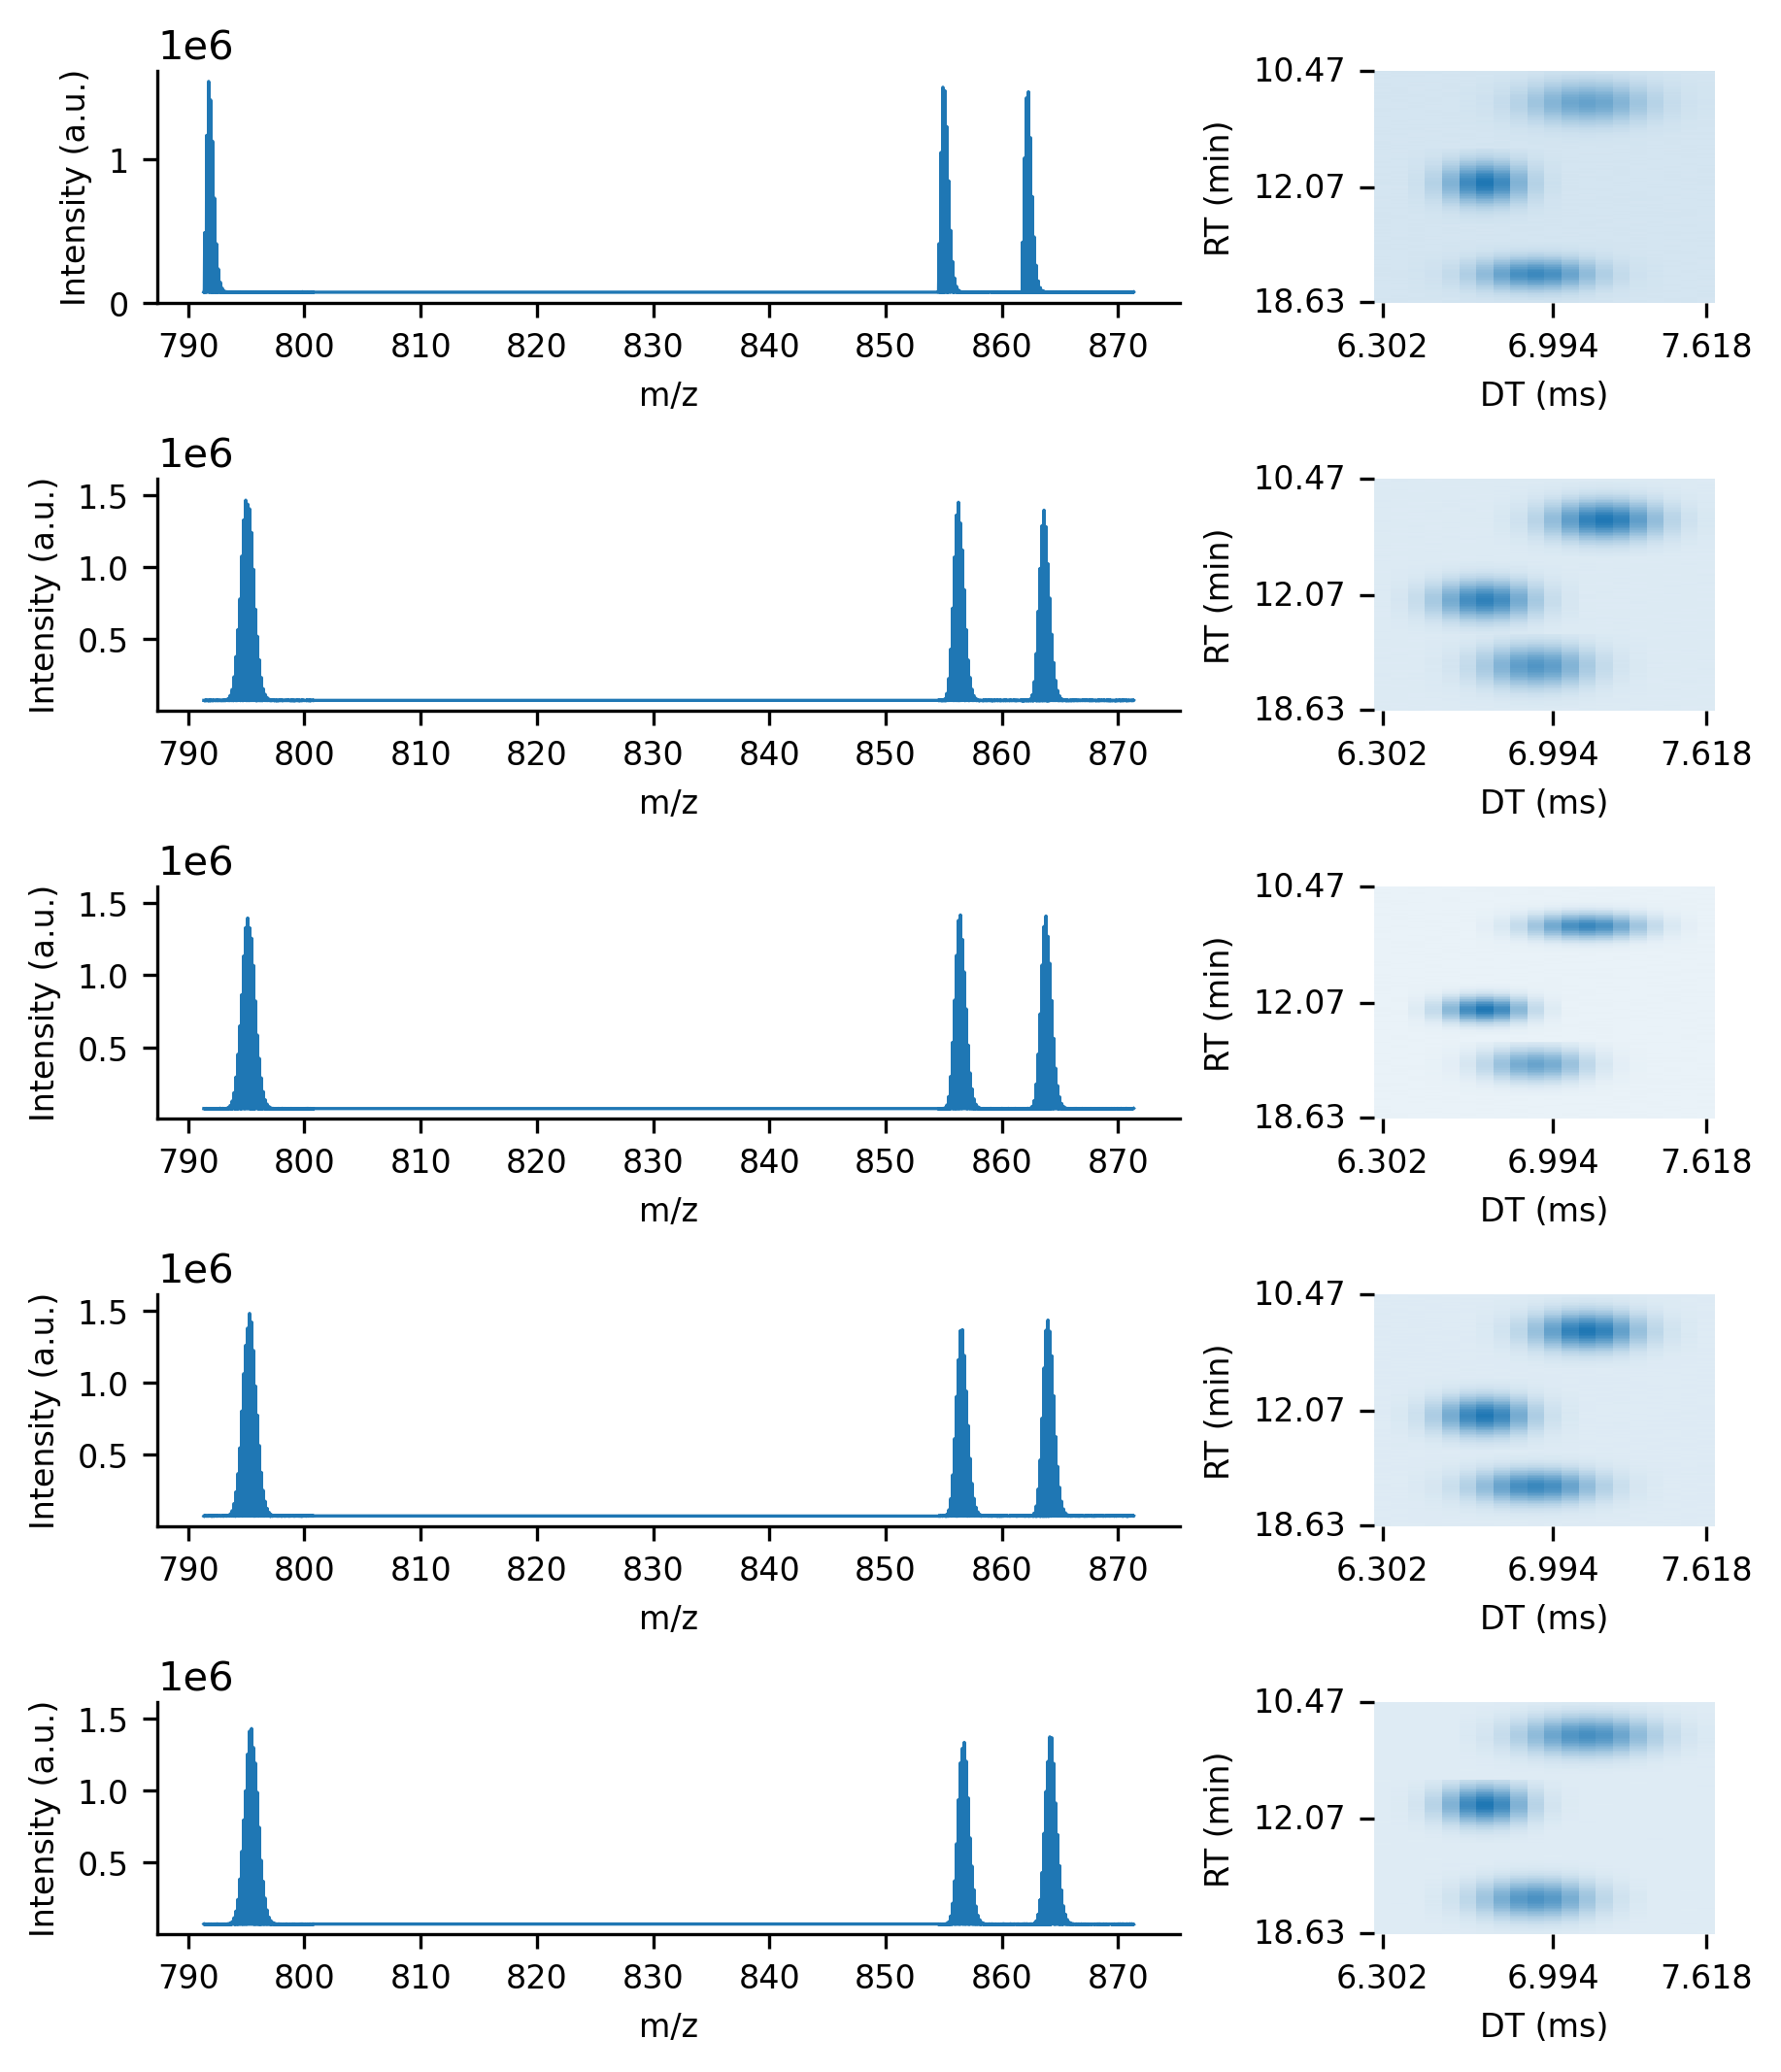

In [15]:
fig, ax, ymax = mhdx_plot.plot_tensor(comb, noisy[:5])

In [16]:
output_dir = '../datasets/combined_tensors'


if not os.path.isdir(output_dir):
    os.makedirs(output_dir)


output_path = output_dir + "/" + "Combined_0-2.npz"

In [ ]:
io.save_combined_npz(output_path, final, t, rt, dt, mz,
                  meta={"source_paths": tensors, "weights": weights})

tensor, t, rt, dt, mz, meta = io.load_combined_npz(output_path)

In [ ]:
meta